# Import Libraries/Packages & Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)

## Set Working directory
## Load benign data, drop unwanted columns
 

In [2]:
#load data
import os
attackdata = {}
os.chdir('C:/Final Year Project/idsattacks')
for i in os.listdir():
  if i != 'Benign.csv':
    attackdata[i] = pd.read_csv(i)
    attackdata[i].drop(['Dst Port', 'Timestamp', 'Flow Byts/s', 'Flow Pkts/s'], axis=1, inplace=True)


In [3]:
for i in attackdata:
    print(i, attackdata[i].shape)

Bot.csv (286191, 76)
Brute Force -Web.csv (611, 76)
Brute Force -XSS.csv (230, 76)
DDOS attack-HOIC.csv (686012, 76)
DDOS attack-LOIC-UDP.csv (1730, 76)
DDoS attacks-LOIC-HTTP.csv (576191, 76)
DoS attacks-GoldenEye.csv (41508, 76)
DoS attacks-Hulk.csv (461912, 76)
DoS attacks-SlowHTTPTest.csv (139890, 76)
DoS attacks-Slowloris.csv (10990, 76)
FTP-BruteForce.csv (193354, 76)
Infilteration.csv (160739, 76)
SQL Injection.csv (87, 76)
SSH-Bruteforce.csv (187589, 76)


In [4]:
bendata = pd.read_csv('C:/Final Year Project/idsattacks/Benign.csv')
#bendata.drop(['Unnamed: 0'], axis=1, inplace=True)
print(bendata.shape)

(2457307, 77)


In [5]:
#checking for unwanted columns
for i in attackdata:
  for j in ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Protocol']:
    if j in attackdata[i].columns:
      attackdata[i].drop([j], axis=1, inplace=True)

In [6]:
for i in ['Unnamed: 0','Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Flow Byts/s', 'Flow Pkts/s', 'Protocol']:
    if i in bendata.columns:
      print('bendata' + " : " + i)
      bendata.drop([i], axis=1, inplace=True)
#bendata.drop(['Unnamed: 0'],axis=1,inplace=True)

bendata : Unnamed: 0
bendata : Protocol


In [7]:
print(bendata.shape)

(2457307, 75)


In [8]:
#full data combined
fulldata = pd.DataFrame()
for i in attackdata:
    fulldata = pd.concat([fulldata, attackdata[i]], axis=0)
fulldata = pd.concat([fulldata, bendata], axis=0)
fulldata

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,16079,3,4,326.0,129.0,326.0,0.0,108.666667,188.216188,112.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
1,577,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
2,10279,3,4,326.0,129.0,326.0,0.0,108.666667,188.216188,112.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
3,457,2,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
4,10271,3,4,326.0,129.0,326.0,0.0,108.666667,188.216188,112.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2457302,318,2,2,74.0,338.0,37.0,37.0,37.000000,0.000000,205.0,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2457303,1131,1,1,61.0,122.0,61.0,61.0,61.000000,0.000000,122.0,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2457304,1109,2,2,100.0,257.0,50.0,50.0,50.000000,0.000000,146.0,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2457305,866,2,2,74.0,338.0,37.0,37.0,37.000000,0.000000,205.0,...,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [9]:
#storing columns
fulldatacols = list(fulldata.columns)
fulldatacols.remove('Label')
len(fulldatacols)

74

In [10]:
#fulldata labels
fulldatalabels = fulldata['Label']
fulldata.drop(['Label'], axis=1, inplace=True)

In [11]:
des = fulldata.describe()
cols = []
for i in fulldatacols:
    if des[i]['max'] == 0:
        cols.append(i)
        print(i, des[i]['min'], des[i]['max'])

Bwd PSH Flags 0.0 0.0
Bwd URG Flags 0.0 0.0
Fwd Byts/b Avg 0.0 0.0
Fwd Pkts/b Avg 0.0 0.0
Fwd Blk Rate Avg 0.0 0.0
Bwd Byts/b Avg 0.0 0.0
Bwd Pkts/b Avg 0.0 0.0
Bwd Blk Rate Avg 0.0 0.0


In [12]:
fulldata.drop(cols, axis=1, inplace=True)

In [13]:
for i in cols:
    fulldatacols.remove(i)

In [14]:
#scaling data
scaler = MinMaxScaler((0, 100))
fulldata = scaler.fit_transform(fulldata)

In [15]:
fulldata = pd.DataFrame(fulldata, columns=fulldatacols)

In [16]:
fulldata

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.013399,0.000646,0.021256,0.003290,0.000469,17.340426,0.000000,7.461548,14.158398,2.791625,...,0.000323,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000481,0.000323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.008566,0.000646,0.021256,0.003290,0.000469,17.340426,0.000000,7.461548,14.158398,2.791625,...,0.000323,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000381,0.000323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.008559,0.000646,0.021256,0.003290,0.000469,17.340426,0.000000,7.461548,14.158398,2.791625,...,0.000323,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204336,0.000265,0.000323,0.010628,0.000747,0.001229,1.968085,2.612994,2.540588,0.000000,5.109671,...,0.000323,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5204337,0.000943,0.000000,0.005314,0.000616,0.000444,3.244681,4.307910,4.188538,0.000000,3.040877,...,0.000000,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5204338,0.000924,0.000323,0.010628,0.001009,0.000935,2.659574,3.531073,3.433228,0.000000,3.639083,...,0.000323,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5204339,0.000722,0.000323,0.010628,0.000747,0.001229,1.968085,2.612994,2.540588,0.000000,5.109671,...,0.000323,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
fulldata.reset_index(inplace=True, drop=True)
fulldatalabels.reset_index(inplace=True, drop=True)
fulldata = pd.concat([fulldata, fulldatalabels], axis=1)

In [18]:
des = fulldata.describe()
cols = []
for i in fulldata.columns:
    if i != 'Label':
        if des[i]['max'] == 0:
            cols.append(i)
            print(i, des[i]['min'], des[i]['max'])

In [19]:
fulldata['Active Mean'].sum()

73187.6189999643

Removing unwanted columns using correlation

In [20]:
'''
corr_matrix = fulldata[fulldatacols].corr().abs()
threshold = 0.99
# Find features with high correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(f"The following {len(to_drop)} features will be dropped due to high correlation: {to_drop}")
'''

'\ncorr_matrix = fulldata[fulldatacols].corr().abs()\nthreshold = 0.99\n# Find features with high correlation\nupper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))\nto_drop = [column for column in upper.columns if any(upper[column] > threshold)]\nprint(f"The following {len(to_drop)} features will be dropped due to high correlation: {to_drop}")\n'

In [21]:
'''
fulldata = fulldata.drop(to_drop, axis = 1)
fulldatacols = list(fulldata.columns)
len(fulldatacols)
'''

'\nfulldata = fulldata.drop(to_drop, axis = 1)\nfulldatacols = list(fulldata.columns)\nlen(fulldatacols)\n'

In [22]:
fulldata

,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0.013399,0.000646,0.021256,0.003290,0.000469,17.340426,0.000000,7.461548,14.158398,2.791625,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
1,0.000481,0.000323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
2,0.008566,0.000646,0.021256,0.003290,0.000469,17.340426,0.000000,7.461548,14.158398,2.791625,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
3,0.000381,0.000323,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
4,0.008559,0.000646,0.021256,0.003290,0.000469,17.340426,0.000000,7.461548,14.158398,2.791625,...,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204336,0.000265,0.000323,0.010628,0.000747,0.001229,1.968085,2.612994,2.540588,0.000000,5.109671,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
5204337,0.000943,0.000000,0.005314,0.000616,0.000444,3.244681,4.307910,4.188538,0.000000,3.040877,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
5204338,0.000924,0.000323,0.010628,0.001009,0.000935,2.659574,3.531073,3.433228,0.000000,3.639083,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
5204339,0.000722,0.000323,0.010628,0.000747,0.001229,1.968085,2.612994,2.540588,0.000000,5.109671,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [23]:
for i in attackdata:
    attackdata[i] = fulldata[fulldata['Label'] == i[:-4]]
bendata = fulldata[fulldata['Label'] == 'Benign']

In [24]:
del fulldata

In [25]:
attbenmixdata = {}
mixbendata = bendata[:int(bendata.shape[0]*0.05)]
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    print(i)
    attbenmixdata[i] = pd.concat([attackdata[i][:int(attackdata[i].shape[0]*0.7)], mixbendata], axis=0)
    attbenmixdata[i] = attbenmixdata[i].sample(frac=1).reset_index(drop=True)

Bot.csv
DDOS attack-HOIC.csv
DDoS attacks-LOIC-HTTP.csv
DoS attacks-Hulk.csv
DoS attacks-SlowHTTPTest.csv
FTP-BruteForce.csv
Infilteration.csv
SSH-Bruteforce.csv


In [26]:
for i in attbenmixdata:
  print(i + " : " + str(attbenmixdata[i].shape))
  print(attbenmixdata[i]['Label'].value_counts())

Bot.csv : (323198, 67)
Label
Bot       200333
Benign    122865
Name: count, dtype: int64
DDOS attack-HOIC.csv : (603073, 67)
Label
DDOS attack-HOIC    480208
Benign              122865
Name: count, dtype: int64
DDoS attacks-LOIC-HTTP.csv : (526198, 67)
Label
DDoS attacks-LOIC-HTTP    403333
Benign                    122865
Name: count, dtype: int64
DoS attacks-Hulk.csv : (446203, 67)
Label
DoS attacks-Hulk    323338
Benign              122865
Name: count, dtype: int64
DoS attacks-SlowHTTPTest.csv : (220788, 67)
Label
Benign                      122865
DoS attacks-SlowHTTPTest     97923
Name: count, dtype: int64
FTP-BruteForce.csv : (258212, 67)
Label
FTP-BruteForce    135347
Benign            122865
Name: count, dtype: int64
Infilteration.csv : (235382, 67)
Label
Benign           122865
Infilteration    112517
Name: count, dtype: int64
SSH-Bruteforce.csv : (254177, 67)
Label
SSH-Bruteforce    131312
Benign            122865
Name: count, dtype: int64


In [27]:
attbenmixdatalabels = {}
for i in attbenmixdata:
  attbenmixdatalabels[i] = attbenmixdata[i]['Label']
  attbenmixdata[i].drop(['Label'], axis=1, inplace=True)

In [28]:
#find minimum length for selecting equal number of samples from each class
not_set_len = []
for i in attackdata:
    if attackdata[i].shape[0] < 100000:
        not_set_len.append(attackdata[i].shape[0])
not_set_len = min(not_set_len)

In [29]:
#combine all attack data and get equal number of data from each attack 
selectedattackbenmix = pd.DataFrame()
notselectedattackbenmix = pd.DataFrame()
for i in attackdata:
    if attackdata[i].shape[0] > 100000:
        selectedattackbenmix = pd.concat([selectedattackbenmix, attackdata[i][-10000:]], axis=0)
    else:
        notselectedattackbenmix = pd.concat([notselectedattackbenmix, attackdata[i][-not_set_len:]], axis=0)

In [30]:
#combine selected and not selected attack data with benign data
selectedattackbenmix = pd.concat([selectedattackbenmix, bendata[-10000:]], axis=0)
notselectedattackbenmix = pd.concat([notselectedattackbenmix, bendata[-not_set_len:]], axis=0)
print(selectedattackbenmix['Label'].value_counts())
print(notselectedattackbenmix['Label'].value_counts())

Label
Bot                         10000
DDOS attack-HOIC            10000
DDoS attacks-LOIC-HTTP      10000
DoS attacks-Hulk            10000
DoS attacks-SlowHTTPTest    10000
FTP-BruteForce              10000
Infilteration               10000
SSH-Bruteforce              10000
Benign                      10000
Name: count, dtype: int64
Label
Brute Force -Web         87
Brute Force -XSS         87
DDOS attack-LOIC-UDP     87
DoS attacks-GoldenEye    87
DoS attacks-Slowloris    87
SQL Injection            87
Benign                   87
Name: count, dtype: int64


In [31]:
print('bendata' + " : " + str(bendata.shape))

bendata : (2457307, 67)


In [32]:
len(attackdata)

14

In [33]:
for i in attackdata:
  attackdata[i].drop(['Label'], axis=1, inplace=True)
bendata.drop(['Label'], axis=1, inplace=True)

C:\Users\amenu4aie20110\AppData\Local\Temp\ipykernel_12776\1938366929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attackdata[i].drop(['Label'], axis=1, inplace=True)
C:\Users\amenu4aie20110\AppData\Local\Temp\ipykernel_12776\1938366929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  attackdata[i].drop(['Label'], axis=1, inplace=True)
C:\Users\amenu4aie20110\AppData\Local\Temp\ipykernel_12776\1938366929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [34]:
#printing the shapes of the data
for i in attackdata:
  print(i + " : " + str(attackdata[i].shape))

Bot.csv : (286191, 66)
Brute Force -Web.csv : (611, 66)
Brute Force -XSS.csv : (230, 66)
DDOS attack-HOIC.csv : (686012, 66)
DDOS attack-LOIC-UDP.csv : (1730, 66)
DDoS attacks-LOIC-HTTP.csv : (576191, 66)
DoS attacks-GoldenEye.csv : (41508, 66)
DoS attacks-Hulk.csv : (461912, 66)
DoS attacks-SlowHTTPTest.csv : (139890, 66)
DoS attacks-Slowloris.csv : (10990, 66)
FTP-BruteForce.csv : (193354, 66)
Infilteration.csv : (160739, 66)
SQL Injection.csv : (87, 66)
SSH-Bruteforce.csv : (187589, 66)


In [35]:
for i in attackdata:
    attackdata[i] = attackdata[i].to_numpy()

In [36]:
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    print(int(attackdata[i].shape[0]*0.9), (int(attackdata[i].shape[0]) - int(attackdata[i].shape[0]*0.9)))

257571 28620
617410 68602
518571 57620
415720 46192
125901 13989
174018 19336
144665 16074
168830 18759


In [37]:
#loading data into pytorch dataloader as train and test
devices = []
batch_size = 128
train_loader = {}
test_loader = {}
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    train_loader[i] = torch.utils.data.DataLoader(attackdata[i][:int(attackdata[i].shape[0]*0.9)], batch_size = batch_size, shuffle=True)
    test_loader[i] = torch.utils.data.DataLoader(attackdata[i][int(attackdata[i].shape[0]*0.9):], batch_size = batch_size, shuffle=True)
    devices.append(i)

In [38]:
for i in attackdata:
  if attackdata[i].shape[0] > 100000:
    print(len(test_loader[i]))

224
536
451
361
110
152
126
147


In [39]:
bendata = bendata.to_numpy()

In [40]:
ben_loader = torch.utils.data.DataLoader(bendata[int(bendata.shape[0]*0.9):], batch_size = batch_size, shuffle=True)

In [41]:
for i in attbenmixdata:
    attbenmixdata[i] = attbenmixdata[i].to_numpy()

In [42]:
attbenmixdata_loader = {}
for i in attbenmixdata:
    attbenmixdata_loader[i] = torch.utils.data.DataLoader(attbenmixdata[i], batch_size = batch_size, shuffle=True)

In [43]:
selectedattackbenmix_labels = selectedattackbenmix['Label']
notselectedattackbenmix_labels = notselectedattackbenmix['Label']
selectedattackbenmix.drop(['Label'], axis=1, inplace=True)
notselectedattackbenmix.drop(['Label'], axis=1, inplace=True)

In [44]:
selectedattackbenmix = selectedattackbenmix.to_numpy()
notselectedattackbenmix = notselectedattackbenmix.to_numpy()

In [45]:
selectedattackbenmix_loader = torch.utils.data.DataLoader(selectedattackbenmix, batch_size = batch_size, shuffle=True)
notselectedattackbenmix_loader = torch.utils.data.DataLoader(notselectedattackbenmix, batch_size = batch_size, shuffle=True)

In [46]:
train_loader['Benign.csv'] = ben_loader

In [47]:
devices.append('Benign.csv')

In [48]:
len(train_loader)

9

In [49]:
len(devices)

9

In [50]:
#initialising config variables
num_clients = len(train_loader)      # Number of clients
num_selected = len(train_loader)    # Typically, num_selected is around 30–40% of the num_clients.
#baseline_num = 1000  # choose some data from the train set to retrain the data from trained model
num_rounds = 10  #100      # Total number of communication rounds for the global model to train.
epochs = 30          # for train client model
#retrain_epochs = 3  # Total number of retraining rounds on the global server after receiving the model weights
                      # from all the clients that participated in the communication round.

## FedAvg / FedAvgM

In [51]:
# aggregates the model weights received from every client
# and updates the global model with updated weights

# FedAvg
def server_aggregate(global_model, client_models, client_lens):
    total = sum(client_lens)
    n = len(client_models)
    # n = num_selected
    global_dict = global_model.state_dict()
    for k in global_dict.keys(): # calculate average weight/bias --> avg_w/b
        global_dict[k] -= torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()):
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias



In [52]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    client_model.train()
    for e in range(epoch):
        running_loss = 0.0
        for data in train_data:
          output = client_model(data.float()) # tensor 115
          optimizer.zero_grad()
          # criterion = nn.MSELoss(reduction='mean')
          # loss = criterion(data.to(device), output)
          loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
          loss.backward()
          optimizer.step()
          # print(loss.item())
          running_loss += loss.item()
        # print(running_loss)
        epoch_loss = running_loss/len(train_data)
        # metrics['train_loss'].append(epoch_loss)
    return epoch_loss
    # return loss.item()



# synchronizes the client model with global weights (before training)

def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())

## Deep Auto-encoder Model

In [53]:
import torch.nn as nn

input_dim = train_loader['Benign.csv'].dataset.shape[1]

class AEModel(nn.Module):
    def __init__(self, input_dim):
        super(AEModel, self).__init__()
        
        xavier_gain = nn.init.calculate_gain('tanh')
        
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, 32)  
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 8)
        self.fc6 = nn.Linear(8, 16)
        self.fc7 = nn.Linear(16, 32)
        self.fc8 = nn.Linear(32, input_dim)
        self.fc9 = nn.Linear(input_dim, input_dim)
       
        self.activation = nn.Tanh()
        
        nn.init.xavier_uniform_(self.fc1.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc2.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc3.weight, gain=xavier_gain) 
        nn.init.xavier_uniform_(self.fc4.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc5.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc6.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc7.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc8.weight, gain=xavier_gain)
        nn.init.xavier_uniform_(self.fc9.weight, gain=xavier_gain)
        
    def forward(self, x):
        x = self.fc1(x) 
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x) 
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x) 
        x = self.fc6(x)
        x = self.activation(x)
        x = self.fc7(x)
        x = self.activation(x)
        x = self.fc8(x) 
        x = self.activation(x)
        x = self.fc9(x)
        return x

## Initialisation

In [54]:
# Initializing models and optimizer

global_model = AEModel(input_dim).to(device)
client_models = [AEModel(input_dim).to(device) for _ in range(num_selected)] # part or all clients
# print(client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict())

# method_env = {'lr': (0.012, 0.012, 0.012, 0.0005)}
#opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]
# lr_list = [0.012, 0.012, 0.012, 0.00005]
# # opt = [torch.optim.SGD(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05, momentum=0.9) for model in client_models]
# opt = [torch.optim.Adam(model.parameters(), lr = lr_list[client_models.index(model)], weight_decay=1e-05) for model in client_models]
opt = [torch.optim.Adam(model.parameters(), lr = 0.012, weight_decay=1e-05) for model in client_models]

# Training Federated Model

In [61]:
# Train Client Model and Global Model
train_loss_client = []
train_loss_global = []
train_loss_per_client = [[] for i in range(num_clients)]
train_loss_benign = []

start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    #client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    client_idx = list(range(num_clients))
    print('client_idx: ', client_idx)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] # Need to fix this. It is part of server aggregation.
    # client_lens = [len(train_lotrain_loaderader[idx]) for idx in client_idx ]
    #print(client_lens)


    #### client update ####
    loss = 0
    for i in tqdm(range(num_selected-1)): # num_selected-1 because last client is benign
        # print(i)
        client_syn(client_models[i], global_model)
        # print(train_loader[devices[client_idx[i]]])
        l = client_update(client_models[i], opt[i], train_loader[devices[client_idx[i]]], epochs)
        train_loss_per_client[i].append(l)
        loss += l
    train_loss_client.append(loss)

    #### benign client update ####
    for i in tqdm(range(1)):
        l = client_update(client_models[-1], opt[-1], train_loader[devices[client_idx[-1]]], epochs)
        train_loss_benign.append(l)
    train_loss_per_client[-1] = train_loss_benign
    train_loss_client.append(sum(train_loss_benign))


    #### retraining on the global server ####
    #loss_retrain = 0
    #for i in tqdm(range(num_selected)):
    #    loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    #train_loss_global.append(loss_retrain/num_selected)

    attackclients = []
    for i in devices:
        if i != 'Benign.csv':
            attackclients.append(client_models[devices.index(i)])
    
    ### aggregate models ###
    server_aggregate(global_model, attackclients, client_lens)      # FedAvg
    #server_aggregate_M(global_model, attackclients, client_lens)    # FedAvgM

    print("\nclient_loss: ", loss)
    #print('global_loss: ', loss_retrain/num_selected)

time_required = time.time() - start_time
print('/nTIME: {}mins'.format(time_required/60))


round:  1
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [02:51<00:00, 171.83s/it]



client_loss:  649.6205745748607

round:  2
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [06:07<00:00, 367.57s/it]



client_loss:  632.6671980344132

round:  3
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [04:55<00:00, 295.42s/it]



client_loss:  725.2607347688892

round:  4
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [05:14<00:00, 314.36s/it]



client_loss:  671.2616022533974

round:  5
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [05:40<00:00, 340.60s/it]



client_loss:  567.9093171532734

round:  6
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [06:06<00:00, 366.50s/it]



client_loss:  442.47212789669567

round:  7
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [05:29<00:00, 329.63s/it]



client_loss:  220.26068172051023

round:  8
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [08:22<00:00, 502.53s/it]



client_loss:  576.8955320837031

round:  9
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [06:31<00:00, 391.66s/it]



client_loss:  527.0657802443228

round:  10
client_idx:  [0, 1, 2, 3, 4, 5, 6, 7, 8]


100%|██████████| 1/1 [06:08<00:00, 368.79s/it]


client_loss:  551.7056388567815
/nTIME: 683.2467776616414mins


In [62]:
for i in range(len(train_loss_per_client)):
  print(train_loss_per_client[i])

[155.39759311969755, 155.39212599336005, 155.3835383423276, 1.354668742232441, 155.37272843400223, 0.832687278374404, 1.9392779265945408, 155.36611357839084, 109.36942584465164, 155.12466373055122]
[125.18416735869204, 135.2945189167611, 135.30158561023313, 135.31044651461676, 134.89079880583444, 87.92165958392859, 95.04037472275843, 135.30989286476503, 39.49133426286967, 127.91308021504906]
[182.3884624411064, 124.56393284658807, 188.0968091010106, 188.03486516186186, 13.785939910216486, 14.235393963585013, 13.817887457843359, 130.85473701513766, 13.726814602228638, 188.19619161402485]
[18.70722847431898, 18.54891682303341, 18.67773967597799, 18.679279878001495, 18.678141405668313, 18.67799247409506, 18.6769428147471, 18.68465442182909, 12.252298431204897, 8.218597376663839]
[1.3986541706372082, 1.3996343572692174, 1.3992672094363507, 1.399587667085291, 1.39943663382191, 1.3996776190957403, 1.3989196551766823, 1.3983855570356052, 1.3987302353105895, 1.399136441933915]
[5.5760044707971

In [63]:
# save model
torch.save(global_model,'C:/Final Year Project/models/globalattackmodel.pt')

In [64]:
for i in range(len(devices)):
  torch.save(client_models[i],'C:/Final Year Project/models/clients/' + devices[i] + '.pt')

In [65]:
losspic = 1
def printperformance(losses, modelname):
    global losspic
    plt.plot(losses)
    plt.xlabel('number of rounds')
    plt.ylabel('loss')
    plt.ylim((0, 2.5))
    plt.grid()
    plt.title(modelname)
    plt.show()
    plt.savefig("C:/Final Year Project/images/" + str(modelname) + str(losspic) + ".png")
    losspic += 1

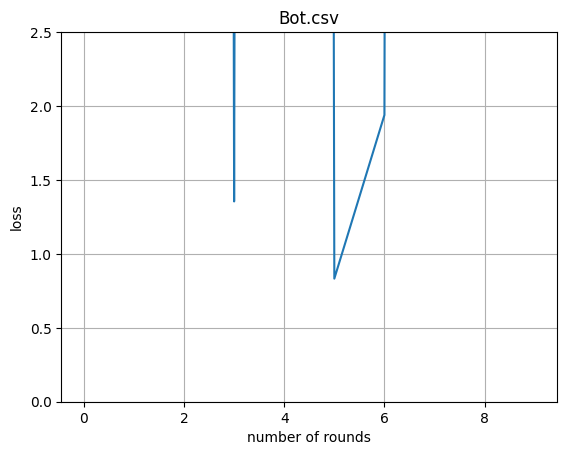

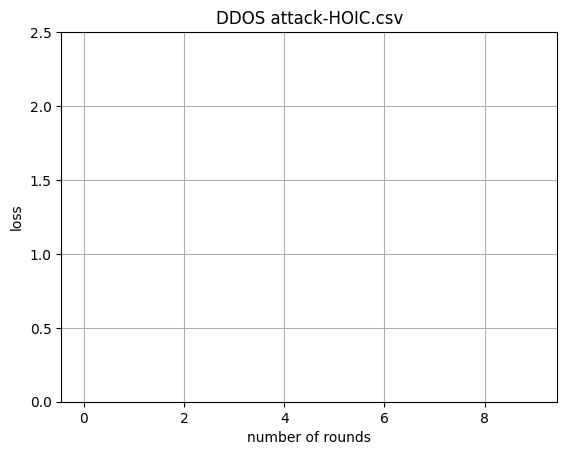

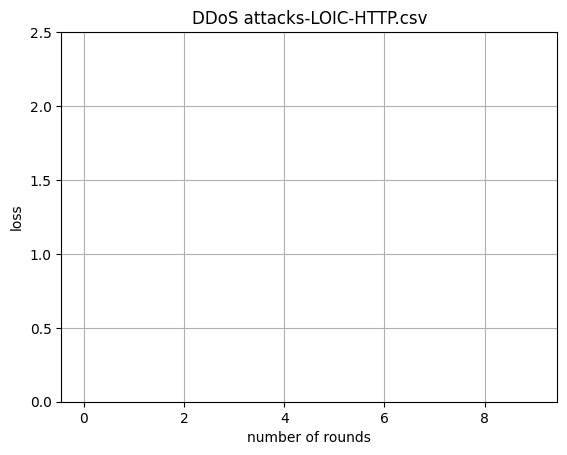

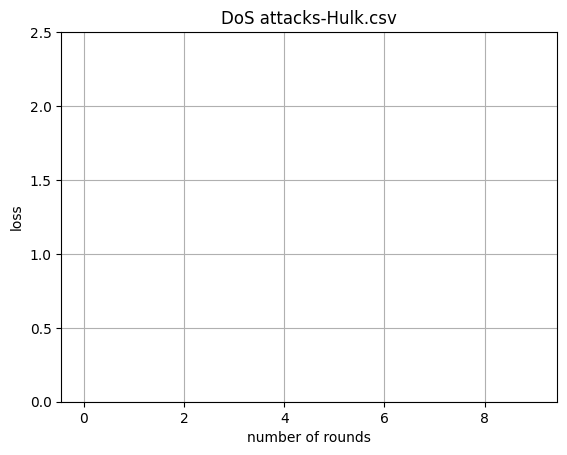

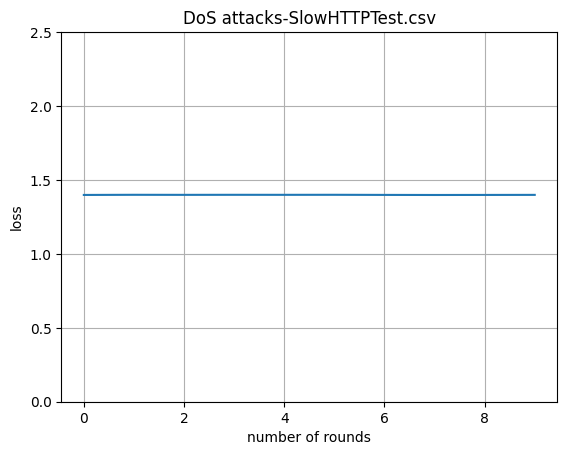

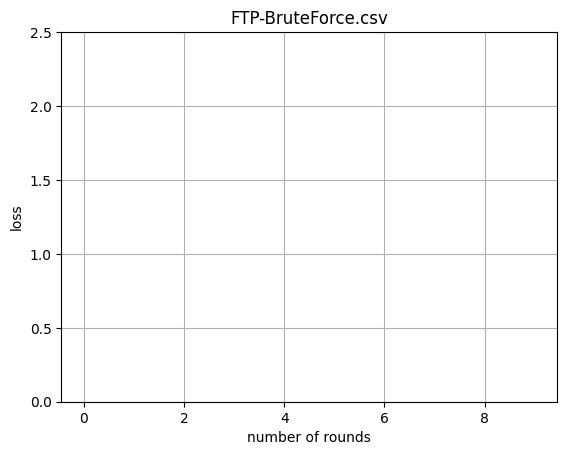

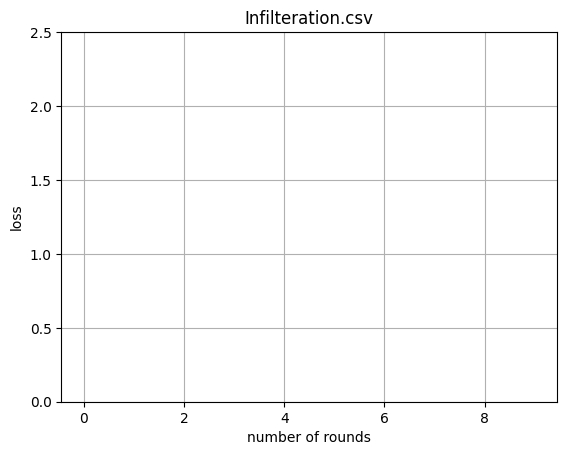

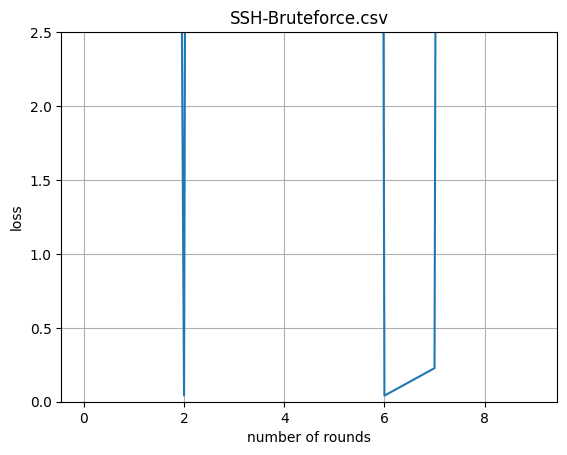

<Figure size 640x480 with 0 Axes>

In [66]:
for i in range(len(devices)-1):
  printperformance(train_loss_per_client[i], devices[i])

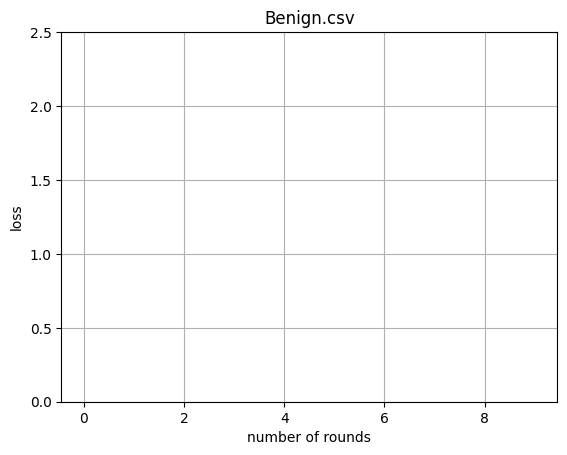

<Figure size 640x480 with 0 Axes>

In [67]:
# print performance of benign client
printperformance(train_loss_benign, devices[-1])

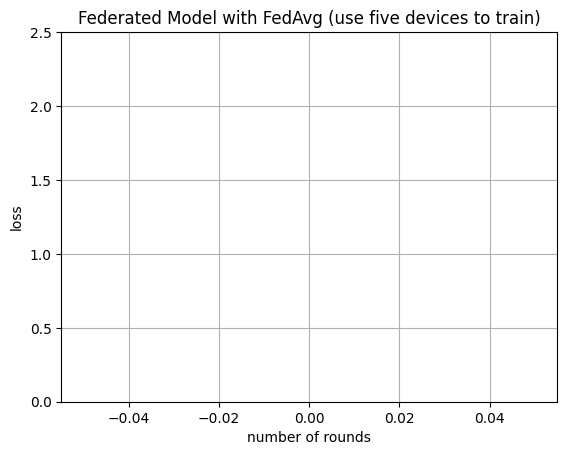

<Figure size 640x480 with 0 Axes>

In [68]:
# train_loss_global
plt.plot(train_loss_global)
plt.xlabel('number of rounds')
plt.ylabel('loss')
plt.ylim((0, 2.5))
plt.grid()
plt.title('Federated Model with FedAvg (use five devices to train)')
plt.show()
plt.savefig("C:/Final Year Project/images/Global10.png")

# Evaluation

In [55]:
client_models = []
for i in range(len(devices)):
  client_models.append(torch.load('C:/Final Year Project/models/clients/' + devices[i] + '.pt'))

In [56]:
from sklearn import metrics

In [87]:
def get_thresh(model, dataloader):

    model.eval()
    errs = []
    mses = []
    for batch in dataloader:
       for data in batch:
         mse = np.power(data.float().cpu().detach().numpy() - model(data.float()).cpu().detach().numpy(), 2) #before np.mean(..., axis=0) (len(mse) = 56)
         mses.append(mse)
    mses = np.array(mses)
    print("MSES: " + str(mses.shape))
    thresh = mses.mean(axis=0) + mses.std(axis=0)
    print(thresh.shape)
    #errs.append(thresh)
    #thresh = sum(errs) / len(errs)
    return thresh

    #model.eval()
    #pred = global_model(tr_data).cpu().detach().numpy()
    #print(pred)
    #print(np.isnan(pred))
    #thresh = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
    #mse = np.mean(np.power(tr_data.cpu().detach().numpy() - model(tr_data).cpu().detach().numpy(), 2), axis=1)
    #tr = np.sqrt(metrics.mean_squared_error(model(tr_data).cpu().detach().numpy(), tr_data.cpu().detach().numpy()))
    #tr = np.sqrt(mse)
    #return thresh

    
def quan_thresh(model, dataloader, quantile=0.9):

  model.eval()
  errs = []
  mse = []
  
  for batch in dataloader:
    
    for data in batch:
      error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2) # len(error) = 56
      mse.append(error)
    # Calculate threshold as quantile of errors 
    thresh = np.quantile(mse, quantile, axis=0) #before it was thresh = np.quantile(mse, quantile)
    errs.append(thresh)
  #thresh = np.quantile(mse, quantile)
  return np.mean(errs) #before it was np.mean(errs)
  #return thresh

def quan_recon(model, dataloader, quantile=0.8):
  model.eval()
  datas = []
  for batch in dataloader:
    for data in batch:
      datas.append(model(data.float()).cpu().detach().numpy())
  thresh = np.quantile(datas, quantile, axis=0)
  return thresh

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)):
        if y_actual[i] == y_pred[i] == 1:
           TP += 1
        if y_pred[i] == 1 and y_actual[i] != y_pred[i]:
           FP += 1
        if y_actual[i] == y_pred[i] == 0:
           TN += 1
        if y_pred[i] == 0 and y_actual[i] != y_pred[i]:
           FN += 1
    return (TP, FP, TN, FN)

def get_mix_result(model, tr, mix_data, mix_label):
    model.eval()
    prediction = []
    for i in mix_data:
      pred = model(i).cpu().detach().numpy()
      error = np.sqrt(metrics.mean_squared_error(pred, threshben.numpy()))
      if error > tr:
        prediction.append(1)
      else:
        prediction.append(0)

    mix_label_list = mix_label.tolist()

    TP,FP,TN,FN = perf_measure(mix_label_list, prediction)

    conf = [[TP, FN],[FP, TN]]
    print(conf)
    x_axis_label = ['abnormal', 'benign']
    y_axis_label = ['abnormal', 'benign']

    plt.figure()
    sns.heatmap(conf,xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True,annot_kws={"size": 16},fmt='g')

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    print('Acc: %.3f%% \nPrecision: %.3f \nRecall: %.3f \nF1score: %.3f \nTPR: %.5f \nFPR: %.5f'%(acc*100,
                                                                                                   precision,
                                                                                                   recall,
                                                                                                   F1score*100,
                                                                                                   TPR,
                                                                                                   FPR))

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [88]:
thresholds = {}
for i in range(len(devices)):
    model = client_models[i]
    dataloader = train_loader[devices[i]]
    thresholds[devices[i]] = quan_thresh(model, dataloader)
    #thresholds[devices[i]] = quan_recon(model, dataloader)
print(thresholds)

In [ ]:
'''thresholds_test = {}
for i in range(len(devices)):
    model = client_models[i]
    dataloader = test_loader[devices[i]]
    thresholds_test[devices[i]] = get_thresh(model, dataloader)
print(thresholds_test)'''

'thresholds_test = {}\nfor i in range(len(devices)):\n    model = client_models[i]\n    dataloader = test_loader[devices[i]]\n    thresholds_test[devices[i]] = get_thresh(model, dataloader)\nprint(thresholds_test)'

In [ ]:
len(thresholds)

9

In [ ]:
devices

['Bot.csv',
 'DDOS attack-HOIC.csv',
 'DDoS attacks-LOIC-HTTP.csv',
 'DoS attacks-Hulk.csv',
 'DoS attacks-SlowHTTPTest.csv',
 'FTP-BruteForce.csv',
 'Infilteration.csv',
 'SSH-Bruteforce.csv',
 'Benign.csv']

In [ ]:
test_loader

{'Bot.csv': <torch.utils.data.dataloader.DataLoader at 0x2a053d13070>,
 'DDOS attack-HOIC.csv': <torch.utils.data.dataloader.DataLoader at 0x2a053d12ec0>,
 'DDoS attacks-LOIC-HTTP.csv': <torch.utils.data.dataloader.DataLoader at 0x2a053d13f40>,
 'DoS attacks-Hulk.csv': <torch.utils.data.dataloader.DataLoader at 0x2a053d12710>,
 'DoS attacks-SlowHTTPTest.csv': <torch.utils.data.dataloader.DataLoader at 0x2a053d128f0>,
 'FTP-BruteForce.csv': <torch.utils.data.dataloader.DataLoader at 0x2a053d12ef0>,
 'Infilteration.csv': <torch.utils.data.dataloader.DataLoader at 0x2a053d122f0>,
 'SSH-Bruteforce.csv': <torch.utils.data.dataloader.DataLoader at 0x2a053d13160>}

### What the model is supposed to find = 1 (Error < Threshold)
### What the model is not supposed to find = 0 (Error > Threshold)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata
matrices=[]
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
  
  model = client_models[device_idx[device]]
  model.eval()
  threshold = thresholds[device]
  for i in attbenmixdata_loader:
    test_set = attbenmixdata_loader[i]
    labels = list(attbenmixdatalabels[i])
    y_true = []
    y_pred = []
    for batch in test_set:
      for data in batch:
        #pred = model(data.float()).cpu().detach().numpy()
        error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2)
        #threshold_ranked = rankdata(threshold)
        #pred_ranked = rankdata(pred)
        #coeff, p = spearmanr(threshold_ranked, pred_ranked)
        if device == i:
          y_true.append(1)
          y_pred.append(1 if error < threshold else 0)
        else:
          y_true.append(0)
          y_pred.append(0 if error >= threshold else 1)
    TP, FP, TN, FN = perf_measure(y_true, y_pred)
    TP += 1
    FN += 1
    TN += 1
    FP += 1
    conf_matrix = [[TP, FN], [FP, TN]]
    plt.figure() 
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion Matrix for Client " + str(device) +" with "+ str(i))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    matrices.append([str("Stats for Client " + str(device) +" with "+ str(i)),acc*100,precision,recall,F1score*100,TPR,FPR])

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [ ]:
for i in matrices:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Plot for global model

In [ ]:
# load model
global_model = torch.load('C:/Final Year Project/models/globalattackmodel.pt')                                        

# Testing client models with equal number of all data (selected and not selected)

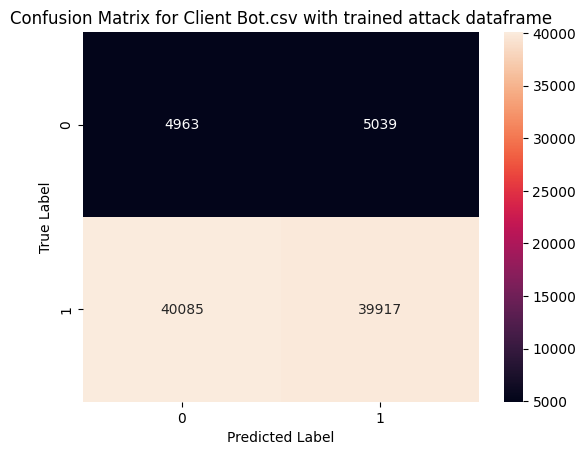

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata, pearsonr
from sklearn.metrics import mutual_info_score
selectedattackbenmix_stats = []
cf=[]
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
  if device == 'Bot.csv':
    model = client_models[device_idx[device]]
    model.eval()
    labels = list(selectedattackbenmix_labels)
    threshold = thresholds[device]
    y_true = []
    y_pred = []
    test_set = selectedattackbenmix_loader
    ind = 0
    for batch in test_set:
      for data in batch:
        #pred = model(data.float()).cpu().detach().numpy()
        #pred_ranked = rankdata(pred)
        #threshold_ranked = rankdata(threshold)
        #coeff, p = pearsonr(threshold, pred)
        error = np.mean(np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2))
        if device[:-4] == labels[ind]:
            y_true.append(1)
            y_pred.append(1 if error < threshold else 0)
        else:
            y_true.append(0)
            y_pred.append(0 if error >= threshold else 1)
        #cf.append([coeff, p, device[:-4] == labels[ind]])
        ind += 1
    TP, FP, TN, FN = perf_measure(y_true, y_pred)
    TP += 1
    FN += 1
    TN += 1
    FP += 1
    conf_matrix = [[TP, FN], [FP, TN]]
    plt.figure() 
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    plt.title("Confusion Matrix for Client " + str(device) +" with trained attack dataframe")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6)
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    selectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with trained attack dataframe"),acc*100,precision,recall,F1score*100,TPR,FPR])

  #   [['TP', 'FN']
  #   ['FP', 'TN']]

In [83]:
cf[:100]

[[0.7789931171972233, 1.3428127625645602e-14, True],
 [0.5582733738388539, 1.1125209896802275e-06, True],
 [0.8432085024388756, 6.565772572622583e-19, True],
 [0.30139753526513846, 0.013922302243070452, True],
 [0.7425626127636669, 9.566173319206277e-13, True],
 [0.8457916094509705, 4.023561548932235e-19, True],
 [0.7789947721679359, 1.3425282759108361e-14, True],
 [0.8864638297475614, 4.2930291820173664e-23, True],
 [0.08664530562564975, 0.48908613279573926, True],
 [0.638162609675564, 8.221729441130455e-09, True],
 [0.30139753526513846, 0.013922302243070452, True],
 [0.7205102598222962, 9.08558255717834e-12, True],
 [0.5973496681909499, 1.191953196077221e-07, True],
 [0.7045886318116451, 4.0576287982876476e-11, True],
 [0.8432085024388756, 6.565772572622583e-19, True],
 [0.8432085024388756, 6.565772572622583e-19, True],
 [0.7767990595568282, 1.7754906635096883e-14, True],
 [0.30139753526513846, 0.013922302243070452, True],
 [0.08536188906075595, 0.49556872233093496, True],
 [0.046209

In [84]:
cf[-100:]

[[0.7790003553255149, 1.3415689671741422e-14, False],
 [0.35765009708369594, 0.003195940560501075, False],
 [0.47372097902436283, 5.880811973817382e-05, False],
 [0.8014407221888227, 6.338912844350617e-16, False],
 [0.7789868951024942, 1.3438828476958664e-14, False],
 [0.8864111535610909, 4.353584241015057e-23, False],
 [0.8432085024388756, 6.565772572622583e-19, False],
 [0.5891490812069482, 1.951962376049455e-07, False],
 [0.7762076662271948, 1.9132899479124984e-14, False],
 [0.8432085024388756, 6.565772572622583e-19, False],
 [0.7425626127636669, 9.566173319206277e-13, False],
 [0.8475580445681562, 2.8636740703416703e-19, False],
 [0.08583362288820083, 0.49318078261815507, False],
 [0.47372097902436283, 5.880811973817382e-05, False],
 [0.47372097902436283, 5.880811973817382e-05, False],
 [0.590635380329935, 1.7868445424609665e-07, False],
 [0.8454842922120616, 4.266935825096524e-19, False],
 [0.8857504619473437, 5.186695008752187e-23, False],
 [0.35765009708369594, 0.003195940560501

In [85]:
for i in selectedattackbenmix_stats:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Title: Stats for Client Bot.csv with trained attack dataframe
Accuracy: 49.86445046886805
Precision: 0.11017137275794708
Recall: 0.4962007598480304
F1 score : 18.03088101725704
TPR : 0.496201
FPR : 0.50105


In [ ]:
import matplotlib
matplotlib.pyplot.close()

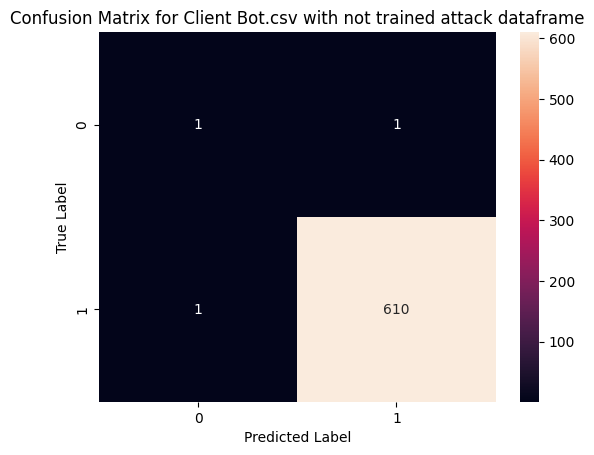

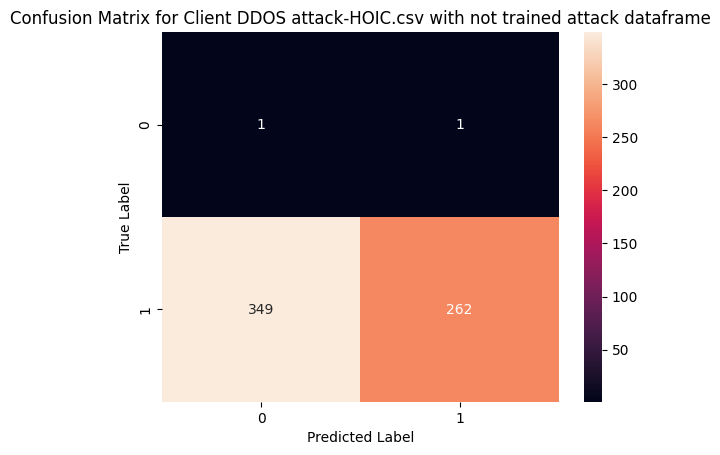

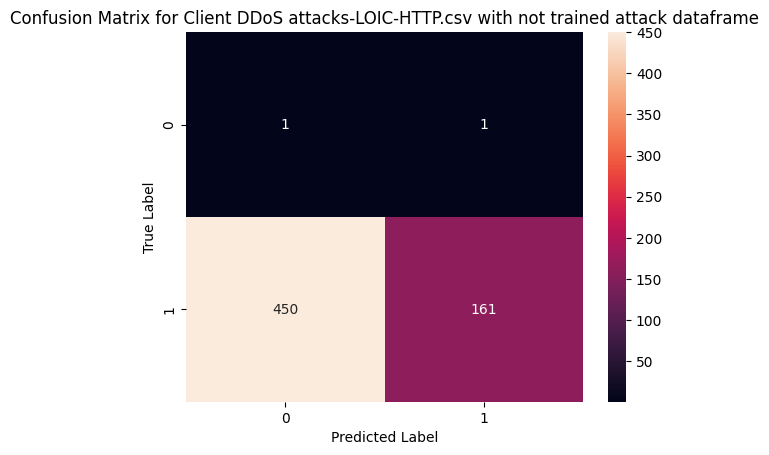

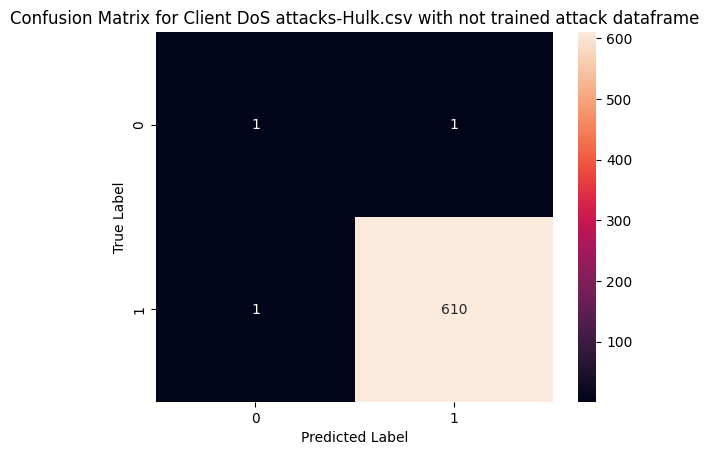

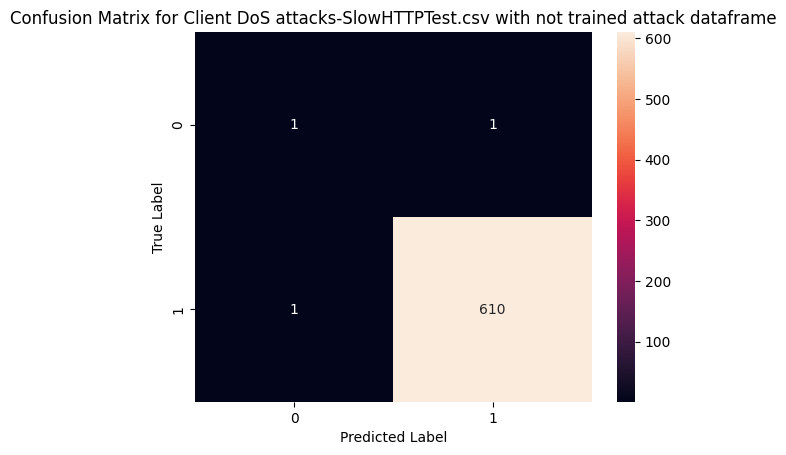

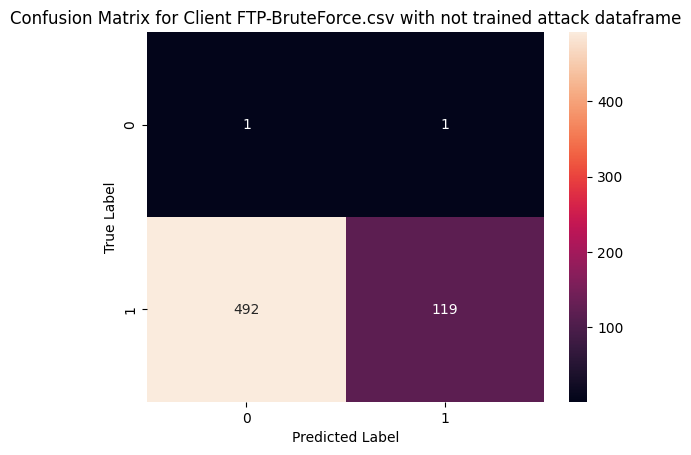

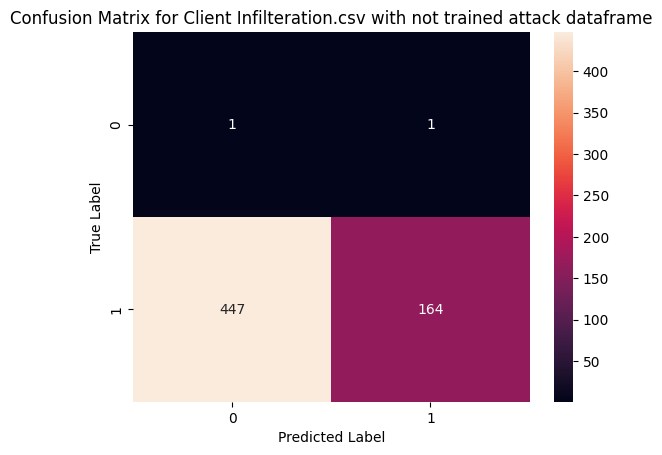

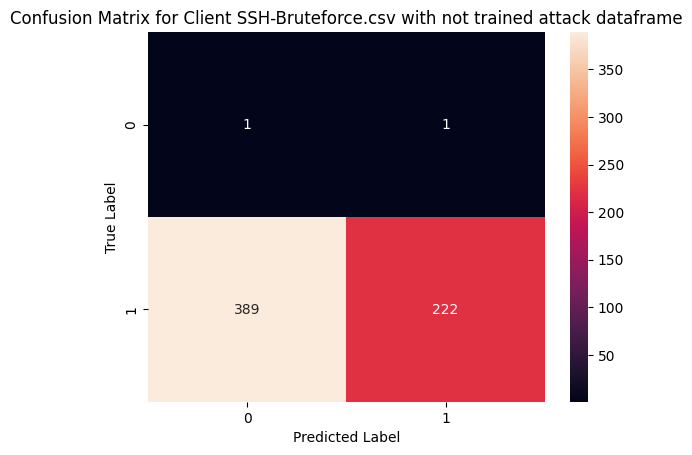

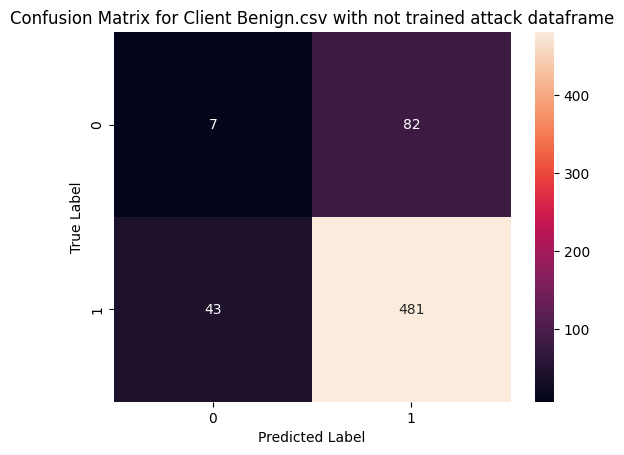

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, rankdata
notselectedattackbenmix_stats = []
device_idx = {device: i for i, device in enumerate(devices)}
for device in devices:
  model = client_models[device_idx[device]]
  model.eval()
  threshold = thresholds[device]
  labels = list(notselectedattackbenmix_labels)
  y_true = []
  y_pred = []
  test_set = notselectedattackbenmix_loader
  ind = 0
  for batch in test_set:
    for data in batch:
      error = np.power(data.float().cpu().numpy() - model(data.float()).cpu().detach().numpy(), 2)
      threshold_ranked = rankdata(threshold)
      error_ranked = rankdata(error)
      coeff, p = spearmanr(threshold_ranked, error_ranked)
      if device[:-4] == labels[ind]:
          y_true.append(1)
          y_pred.append(1 if 0.75 <= coeff else 0)
      else:
          y_true.append(0)
          y_pred.append(0 if 0.75 >= coeff else 1)
      ind += 1
  TP, FP, TN, FN = perf_measure(y_true, y_pred)
  TP += 1
  FN += 1
  TN += 1
  FP += 1
  conf_matrix = [[TP, FN], [FP, TN]]
  plt.figure() 
  sns.heatmap(conf_matrix, annot=True, fmt="d")
  plt.title("Confusion Matrix for Client " + str(device) +" with not trained attack dataframe")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")

  acc = (TP+TN) / (TP+TN+FP+FN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1score = 2 * ((precision * recall) / (precision + recall))

  TPR = round((TP / (TP+FN)), 6)
  # print('TPR is: {}%'.format(TPR))

  FPR = round((FP / (FP + TN)), 6)
  # print('TPR is: {}%'.format(FPR))

  notselectedattackbenmix_stats.append([str("Stats for Client " + str(device) +" with not trained attack dataframe"),acc*100,precision,recall,F1score*100,TPR,FPR])

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [ ]:
for i in notselectedattackbenmix_stats:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Title: Stats for Client Bot.csv with not trained attack dataframe
Accuracy: 99.673735725938
Precision: 0.5
Recall: 0.5
F1 score : 50.0
TPR : 0.5
FPR : 0.001637
Title: Stats for Client DDOS attack-HOIC.csv with not trained attack dataframe
Accuracy: 42.90375203915171
Precision: 0.002857142857142857
Recall: 0.5
F1 score : 0.5681818181818181
TPR : 0.5
FPR : 0.571195
Title: Stats for Client DDoS attacks-LOIC-HTTP.csv with not trained attack dataframe
Accuracy: 26.42740619902121
Precision: 0.0022172949002217295
Recall: 0.5
F1 score : 0.44150110375275936
TPR : 0.5
FPR : 0.736498
Title: Stats for Client DoS attacks-Hulk.csv with not trained attack dataframe
Accuracy: 99.673735725938
Precision: 0.5
Recall: 0.5
F1 score : 50.0
TPR : 0.5
FPR : 0.001637
Title: Stats for Client DoS attacks-SlowHTTPTest.csv with not trained attack dataframe
Accuracy: 99.673735725938
Precision: 0.5
Recall: 0.5
F1 score : 50.0
TPR : 0.5
FPR : 0.001637
Title: Stats for Client FTP-BruteForce.csv with not trained attack

In [ ]:
import matplotlib
matplotlib.pyplot.close()

# Testing global model with equal number of all data (selected only) (not selected does not have threshold)

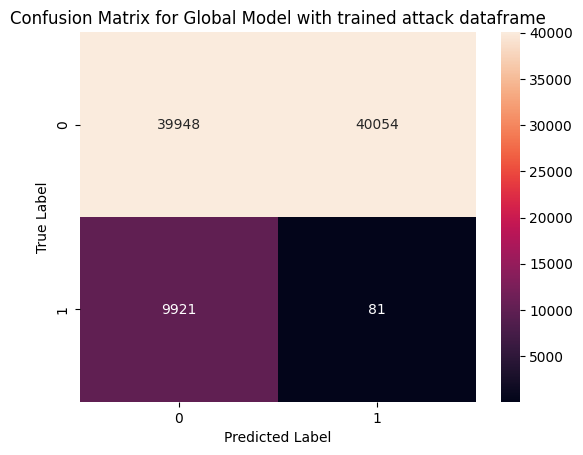

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
selectedattackbenmix_stats_global = []
device_idx = {device: i for i, device in enumerate(devices)}
model = global_model
model.eval()
test_set = selectedattackbenmix_loader
labels = list(selectedattackbenmix_labels)
y_true = []
y_pred = []
ind = 0
for batch in test_set:
    for data in batch:
        pred = model(data.float())
        error = torch.mean((pred.float() - data.float())**2, dim=tuple(range(1,pred.ndim)))
        label = labels[ind]
        threshold = thresholds[label+str('.csv')]
        if label == 'Benign':
            threshold = max(thresholds.values())
            y_true.append(0)
            y_pred.append(0 if error >= threshold else 1)
        else:
            y_true.append(1)
            y_pred.append(1 if error <= threshold else 0)
        ind += 1
TP, FP, TN, FN = perf_measure(y_true, y_pred)
TP += 1
FN += 1
TN += 1
FP += 1
conf_matrix = [[TP, FN], [FP, TN]]
plt.figure() 
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix for Global Model with trained attack dataframe")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

acc = (TP+TN) / (TP+TN+FP+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1score = 2 * ((precision * recall) / (precision + recall))

TPR = round((TP / (TP+FN)), 6)
# print('TPR is: {}%'.format(TPR))

FPR = round((FP / (FP + TN)), 6)
# print('TPR is: {}%'.format(FPR))

selectedattackbenmix_stats_global.append([str("Stats for Globel Model with trained attack dataframe"), acc*100, precision, recall, F1score*100, TPR, FPR])

#   [['TP', 'FN']
#   ['FP', 'TN']]

In [ ]:
for i in selectedattackbenmix_stats_global:
    print("Title: " + i[0])
    print("Accuracy: " + str(i[1]))
    print("Precision: " + str(i[2]))
    print("Recall: " + str(i[3]))
    print("F1 score : " + str(i[4]))
    print("TPR : " + str(i[5]))
    print("FPR : " + str(i[6]))

Title: Stats for Globel Model with trained attack dataframe
Accuracy: 44.47469001377716
Precision: 0.8010587739878482
Recall: 0.49933751656208597
F1 score : 61.519507819297615
TPR : 0.499338
FPR : 0.991902


In [ ]:
import matplotlib
matplotlib.pyplot.close()